In [16]:
""" Spreadsheet Column Printer
à travers ce script on déduplique les données du corpus, pour appliquer des métriques sur les données
la métrique qui a été réussi ici est ROUGE
puis il y a une tentative de calcul de corrélation de Pearson et Spearman
"""

' Spreadsheet Column Printer\nà travers ce script on déduplique les données du corpus, pour appliquer des métriques sur les données\nla métrique qui a été réussi ici est ROUGE\n\n'

In [17]:
import pandas as pd

df = pd.read_csv('../data/histoires_resumes_sentiment.csv')

# Supprimer 2 colonnes
df.drop(columns=["histoire_sentiment", "resume_sentiment"], inplace=True)

# nouveau csv
df.to_csv('../data/histoires_resumes_duplicate.csv', index=False)

In [18]:
!pip install rouge_score

In [19]:
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from rouge_score import rouge_scorer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))


lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Chargement du DataFrame
df = pd.read_csv('../data/histoires_resumes_duplicate.csv')

# initialisation du calculateur de scores ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# initialisation des listes pour stocker les scores
ids = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# pour chaque ligne il calcul le score rouge avec un prétraitement 
for index, row in df.iterrows():
    histoire = row['histoire']
    resume = row['resumes']

    # prétraitement du texte (retirer la ponctuation et les stopwords,  lemmatiser, stemming (enlever les suffixe/prefixes))
    histoire = re.sub(r'[^\w\s]', '', histoire)  
    histoire = ' '.join([lemmatizer.lemmatize(stemmer.stem(w)) for w in word_tokenize(histoire) if w not in stop_words])  

    resume = re.sub(r'[^\w\s]', '', resume)
    resume = ' '.join([lemmatizer.lemmatize(stemmer.stem(w)) for w in word_tokenize(resume) if w not in stop_words])  

    # calcul des scores 
    scores = scorer.score(histoire, resume)

    # ajouter les scores et les ids aux listes
    ids.append(row['id'])
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# nouveau fichier df avec les scores
df_scores = pd.DataFrame({
    'id_histoire': ids,
    'rouge1': rouge1_scores,
    'rouge2': rouge2_scores,
    'rougeL': rougeL_scores
})

# Sauvegarder les scores dans un nouveau fichier CSV
output_file = '../data/histoires_resumes_rouge_scores.csv'
df_scores.to_csv(output_file, index=False, encoding='utf-8')

print(df_scores)

[nltk_data] Downloading package punkt to /home/coco97/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/coco97/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/coco97/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


    id_histoire    rouge1    rouge2    rougeL
0             1  0.019763  0.017822  0.019763
1             2  0.017778  0.016529  0.017778
2             3  0.048900  0.039312  0.048900
3             4  0.009852  0.008876  0.009852
4             5  0.010770  0.009704  0.010770
..          ...       ...       ...       ...
68           69  0.014286  0.012522  0.014286
69           70  0.029851  0.027916  0.029851
70           71  0.026236  0.024267  0.026236
71           72  0.003571  0.002384  0.003571
72           73  0.018706  0.017174  0.018706

[73 rows x 4 columns]


(voir analyse ci-dessous)

In [20]:
# Créer des listes pour stocker les scores
ids = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# Parcours de chaque ligne du DataFrame et calculer les scores ROUGE
for index, row in df.iterrows():
    histoire = row['histoire']
    resume = row['resumes']

    # Calcul des scores ROUGE sans prétraitement
    scores = scorer.score(histoire, resume)

    # Ajout des scores et d ids aux listes
    ids.append(row['id'])
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# nouveau fichier df avec les scores
df_scores = pd.DataFrame({
    'id_histoire': ids,
    'rouge1': rouge1_scores,
    'rouge2': rouge2_scores,
    'rougeL': rougeL_scores
})

# Sauvegarder les scores dans un nouveau fichier CSV
output_file = '../data/histoires_resumes_rouge_scores_no_preprocessing.csv'
df_scores.to_csv(output_file, index=False, encoding='utf-8')

print(df_scores)

    id_histoire    rouge1    rouge2    rougeL
0             1  0.023599  0.022445  0.023599
1             2  0.015689  0.014953  0.015689
2             3  0.041783  0.039106  0.041783
3             4  0.010143  0.009552  0.010143
4             5  0.010013  0.009352  0.010013
..          ...       ...       ...       ...
68           69  0.016511  0.015427  0.016511
69           70  0.028015  0.026829  0.028015
70           71  0.023003  0.021753  0.023003
71           72  0.003681  0.002947  0.003681
72           73  0.018657  0.017740  0.018657

[73 rows x 4 columns]


Les résultats de la métrique ROUGE sont des mesures de similarités de corpus de texte. On retrouve dans ce tableau : 
- une colonne identifiant qui correspond respectivement à chaque paire histoire/résumé, 
- une colonne rouge1 qui correspond à la métrique ROUGE-1, plus précisément le rappel, la précision et le score-F pour les mots individuels. Plus le score est proche de 1 plus, les résumés sont similaires aux histoires.
- une colonne rouge2 qui correspond à la métrique ROUGE-2, contient les mêmes caractéristiques que le 1, mais traite les bigrammes
- une colonne rougeL qui correspond à la métrique ROUGE-L, contient les mêmes caractéristiques que les 2 précédents, mais traite les plus longue sous-séquence commune entre le récit et le résumé .

On peut voir que les scores sont très bas, ce qui laisse penser que les résumés sont peu similaires aux histoires. Je pense que cela est du au fait que les résumés sont très petits, ils font entre une à deux lignes. Les résumés ne sont pas assez développés pour cette raison, les résultats se rapprochent tous de 0. Il n'y a pas beaucoup de mots en commun qui ont été tiré des récits pour écrire les résumés. 

J'ai voulu voir s'il y avait une différence entre un calcul de métrique sur des données prétraité, c'est à dire ne contenant pas de stopwords, de ponctuations et en ayant subit une lemmatisation et un stemming (réduire les mots à leur forme de base) et sur des données non traités. Il n'y a pas de fort changement les résultats restent bas et relativement les mêmes à quelques dizièmes près parfois.

Tentative de la mesure de corrélation, que je n'ai pas réussi. 

In [21]:
!pip install scipy

--------------------------------
mode: two-sided
Pearson: +5.8650e-02; p-value: +6.2209e-01
Spearman: +4.1788e-02; p-value: +7.2557e-01
--------------------------------
mode: greater
Pearson: +5.8650e-02; p-value: +3.1105e-01
Spearman: +4.1788e-02; p-value: +3.6278e-01
--------------------------------
mode: less
Pearson: +5.8650e-02; p-value: +6.8895e-01
Spearman: +4.1788e-02; p-value: +6.3722e-01


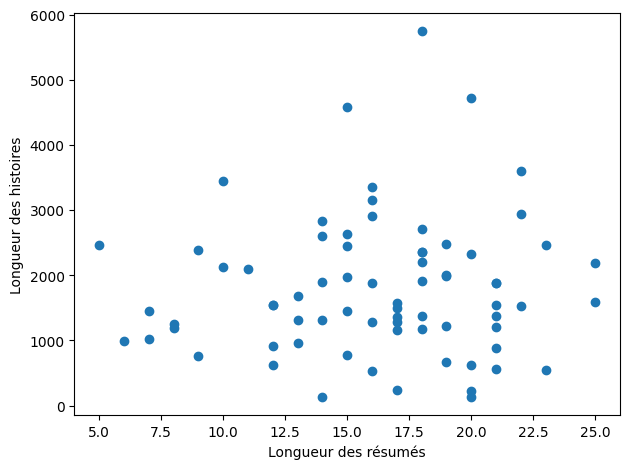

In [22]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Convertir les chaînes de caractères en listes de tokens
# comme dans le fichier script visualise_data on calcul la longueur 
df['h_length'] = df['histoire'].apply(lambda x: len(x.split()))
df['r_length'] = df['resumes'].apply(lambda x: len(x.split()))

a = df['r_length'].values
b = df['h_length'].values

for mode in ["two-sided", "greater", "less"]:
    print("-" * 32)
    print("mode:", mode)
    corr, p = scipy.stats.pearsonr(a,b, alternative=mode)
    print(f"Pearson: {corr:+.4e}; p-value: {p:+.4e}")
    corr, p = scipy.stats.spearmanr(a,b, alternative=mode)
    print(f"Spearman: {corr:+.4e}; p-value: {p:+.4e}")

# affichage du graphique 
plt.scatter(a,b)
plt.xlabel("Longueur des résumés")
plt.ylabel("Longueur des histoires")
plt.tight_layout()
plt.show()

Le graphique ci-dessous représente le calcul des corrélations de Pearson et Spearman entre les longueurs des histoires et des résumés qui ont été scrappé.  On peut constater que les points sur le graphique éparpillés, ils ne suivent aucune direction en particulier. En conclusion, il n'y a aucune corrélation entre les longueurs.